# Introduction

We will have a look at the global mean temperature anomalies from 1850 to today, and explore some visualisations of climate change.

1. First,how have the earth's average atmospheric temperatures changed over the last century?
2. The understanding is clear that atmospheric CO2 levels have a strong green house gas effect on the climate. So we will look into global climate temperatures relate to atmospheric CO2.
3. Is it possible to suggest that the climate change is due to the earth's cyclical solar movements?
4. How do countries fare in their emissions?

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import Wrangler as Wr
import HawkinsStripes as Hs
import Countrypack as Cp

# Function to expand confidence intervals for temperature data
def makeConfidenceInt(data,period):
    upper = period + 'Up'
    lower = period + 'Lo'
    anomaly= period + 'Anomaly'
    uncertainty = period + 'Unc'
    data[upper] = data[anomaly] + data[uncertainty]
    data[lower] = data[anomaly] - data[uncertainty]
    


# Datasets

### 1. Berkeley Earth Land + Ocean Temperature data

Berkeley Earth have provided a very detailed summary dataset of average changes in the Earth's global average surface temperature. The estimation dataset combines the Berkeley Earth land-surface temperature (BEST) field with a reinterpolated version of the Met Office Hadley Centre's sea surface temperature (HadSST) data set.

This data set reports two versions of the summarised average temperatures, which differ in how they treat locations with sea ice. For our report, we will use the version that extrapolates temperature anomalies from land-surface air temperatures in areas where sea ice is present. The other version uses sea-surface water temperature anomalies, which were usually collected from open water areas on the periphery of the sea ice. 

Following the advice of Berkeley Earth, we use air temperatures above sea ice because it provides a more natural means of describing temperature changes in the Earth's surface temperature. While most sea-surface temperatures are close to the near-surface air temperatures, they can differ substantially in open water areas surrounding sea ice. The average air temperature of this data shows larger changes than water sea-surface water temperatures in recent periods. This is in part because water temperature changes are limited by the freezing point of water.

The temperatures in this dataset are in Celcius and are reported as anomalies relative to the Jan 1951 - Dec 1980 average. This allows the data to show global temperature changes over time without being affected by spatial differences between different measuring stations. Uncertainties in the dataset represent the 95% confidence interval for statistical and spacial undersampling effects as well as ocean biases. 

The estimated Jan 1951 - Dec 1980 global mean temperature (C) using air temperature above sea ice is: 

    14.178 +/- 0.048.
    
This dataset reports the estimated global surface temperature anomalies for each month, and its uncertainty. Further, it also reports corresponding values for year, five-year, ten-year, and twenty-year moving averages CENTERED about that month. For example, the annaual average from January to December 1950 is reported at June 1950.

For further details about the Berkeley Earth Land + Ocean Temperature data:
http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt

A brief summary of the strengths and weaknesses of the Berkeley Earth data:
https://climatedataguide.ucar.edu/climate-data/global-surface-temperatures-best-berkeley-earth-surface-temperatures

Further information about Berkeley Earth's data methodology can be found here:
http://berkeleyearth.org/about-data-set/

In [3]:
# Load Global Temperature data
filePath = Wr.makeDirFile('Global_Temperature')
tempdata = pd.read_csv(filePath)

# Convert date to datetime
tempdata.Date = pd.to_datetime(tempdata.Date, format='%Y-%m-%d', errors='coerce')

# Create date index
tempdata = tempdata.set_index('Date')

# Convert string month to categorical datatype
months_order = ['January', 'February', 'March', 'April','May','June',
                'July','August','September','October','November','December']
tempdata.strMonth = pd.Categorical(tempdata.strMonth, 
                     categories=months_order, ordered=True)

The average temperature anomalies are reported as relative a standardised mean of 0.

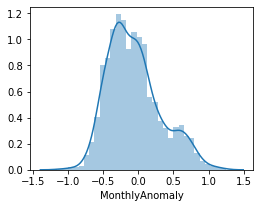

In [4]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.distplot(tempdata.MonthlyAnomaly);

Further, the year, five-year, ten-year and twenty-year moving averages results in trimming the leading and trailing observations up to the number of observations used to calculate an average. For example, the annual average anomalies trims data from the first 5 months and final 6 months in the data. 

In [5]:
print(tempdata.isnull().sum())
# tempdata

Year                   0
Month                  0
MonthlyAnomaly         0
MonthlyUnc             0
AnnualAnomaly         11
AnnualUnc             11
FiveYearAnomaly       59
FiveYearUnc           59
TenYearAnomaly       119
TenYearUnc           119
TwentyYearAnomaly    239
TwentyYearUnc        239
centerMean             0
centerUnc              0
strMonth               0
Country                0
dtype: int64


As the Berkeley Earth data has already filtered duplicates across their data archives, there is no need to further clean duplicate data.

In [6]:
print('Number of duplicates:',tempdata.duplicated().sum())

Number of duplicates: 0


### 1.2 Berkeley Earth Surface Temperature by Country

We also include country data

In [7]:
# Load Country Temperature data
filePath = Wr.makeDirFile('Temp_countries')
cTempdata = pd.read_csv(filePath)

# Convert date to datetime
cTempdata.Date = pd.to_datetime(cTempdata.Date, format='%Y-%m-%d', errors='coerce')

# Create a Month name column
cTempdata['strMonth'] = cTempdata.Date.dt.month_name()

# Create non-index Date
cTempdata['nonIndexDate'] = cTempdata.Date

# set date index
cTempdata = cTempdata.set_index('Date')

# Convert string month to categorical datatype
months_order = ['January', 'February', 'March', 'April','May','June',
                'July','August','September','October','November','December']
cTempdata.strMonth = pd.Categorical(cTempdata.strMonth, 
                     categories=months_order, ordered=True)

### 2. NOAA Mauna Loa Observatory monthly mean CO2

This data shows mean monthly atmospheric carbon dioxide measured at Mauna Loa Observatory, Hawaii. The time period for which the measurements are available are from 1958 to the present.

The data reports the monthly average CO2 mole fraction determined from daily averages. The mole fraction of CO2, expressed as parts per million (ppm), is the number of molecules of CO2 in every one million molecules of dried air (water vapour removed).

Some months in the average CO2 column is missing data. So in addition to the monthly average CO2 column, the data provides an 'interpolated' column which includes average values from the 'average' column, and interpolated values where data are missing.

The interpolated values were computed in two steps: 

    First, the average seasonal cycle for each month was computed in a 7-year window around each monthly value. In this way, the seasonal cycle is allowed to change slowly over time.

    Second, the 'trend' value for each month was determined by removing the seasonal cycle; this result is shown in the 'trend' column. The trend values are linearly interpolated for missing months.

The 'interpolated' monthly mean is therefore the sum of the average seasonal cycle value and the trend value for the missing month.

For more information about the Mauna Loa CO2 data: https://www.esrl.noaa.gov/gmd/ccgg/trends/mlo.html

In [8]:
# Load Global Temperature data
filePath = Wr.makeDirFile('co2_mm_mlo.csv')
co2Data = pd.read_csv(filePath)

# Convert date to datetime
co2Data.Date = pd.to_datetime(co2Data.Date, format='%Y-%m-%d', errors='coerce')

# Create date index
co2Data = co2Data.set_index('Date')

The 'days' column indicates the number of daily average CO2 data computed in the monthly average. Where days equals -1, this means there were no daily averages in computing the month's average.

In [9]:
co2Data

,Year,Month,average,interpolated,trend,days
Date,,,,,,
1958-03-01,1958,3,315.71,315.71,314.62,-1
1958-04-01,1958,4,317.45,317.45,315.29,-1
1958-05-01,1958,5,317.50,317.50,314.71,-1
1958-06-01,1958,6,NaN,317.10,314.85,-1
1958-07-01,1958,7,315.86,315.86,314.98,-1
...,...,...,...,...,...,...
2019-09-01,2019,9,408.54,408.54,412.15,29
2019-10-01,2019,10,408.53,408.53,411.95,30
2019-11-01,2019,11,410.27,410.27,412.27,25


In [10]:
# Note just 7 instances of missing monthly average data
co2Data.isnull().sum()

Year            0
Month           0
average         7
interpolated    0
trend           0
days            0
dtype: int64

### 3. Historical Carbon Dioxide Record from the Vostok Ice Core

Ice cores provide a unique historical record of past atmospheric gas compositions. Small air bubbles are encased in antarctic ice cores over many hundreds of thousands of years, and so enable a direct record of past changes in the atmospheric gas composition. 

For our dataset, we will be using the Vostok Ice core data. The Vostok ice core was drilled in January 1998 at the Russian Vostok station in East Antarctica, yielding the deepest ice core ever recovered. Preliminary records indicate that the Vostok ice core record extends through four climate cycles, with ice slightly older than 400,000 years.

Note that since air bubbles do not close at the surface of the ice sheet, but only near the firn-ice transition (~90m below the surface at Vostok), the air extracted from the ice is youngerthan the surrounding ice. As such, the ice core data provides separate columns for the age of the ice and mean age of the air in years before present (yr BP).

The CO2 concentration estimates for each age are measured in parts per million by volume (ppmv). The CO2 gas concentration estimates from the ice core are similar to the atmospheric CO2 measured in ppm from the data above. 

More information about the Vostok ice corea CO2 data may be found at: https://cdiac.ess-dive.lbl.gov/trends/co2/vostok.html


In [11]:
# Load Vostok ice core CO2 data
filePath = Wr.makeDirFile('vostok_co2')
vosCO2Data = pd.read_csv(filePath)

The data has already been provided in a clean format, with no instances of missing data.

In [12]:
print('Missing data report:')
print(vosCO2Data.isnull().sum())

Missing data report:
Depth_m                 0
Age_of_ice_yrBP         0
Mean_age_of_air_yrBP    0
CO2_conc_ppmv           0
dtype: int64


There are 5 duplicated values in the Age_of_ice_column. However, since the ages are estimated values, these duplicated values generally occur at instances where the depths are 0.01 meters apart from each other. Further, since we are looking at the CO2 concentration in the ice cores, the age variable we are interested in is the mean age of the air.

Within the mean age of air, there is just one duplicated value. This, incidentally, also is a duplicated depth of 3289.45. These observations differ in their CO2 concentrations however. It may be possible that the difference in depth between the two observations was negligibly small, thus appearing as a duplicated depth. 

As we may index the age of the air value for some following analysis, we will keep the first of the duplicate value for simplicity. The difference in CO2 concentrations between the two duplicates appears negligibly small with respect to the range at which CO2 concentrations vary in the ice core.


In [13]:
# vosCO2Data[vosCO2Data.Age_of_ice_yrBP.duplicated()]
vosCO2Data[vosCO2Data.Mean_age_of_air_yrBP.duplicated()]

,Depth_m,Age_of_ice_yrBP,Mean_age_of_air_yrBP,CO2_conc_ppmv
358,3289.45,411202,409022,283.7


In [14]:
vosCO2Data[vosCO2Data.Depth_m.duplicated()]

,Depth_m,Age_of_ice_yrBP,Mean_age_of_air_yrBP,CO2_conc_ppmv
358,3289.45,411202,409022,283.7


In [15]:
vosCO2Data[vosCO2Data.Mean_age_of_air_yrBP.isin([409022])]

,Depth_m,Age_of_ice_yrBP,Mean_age_of_air_yrBP,CO2_conc_ppmv
357,3289.45,411202,409022,281.2
358,3289.45,411202,409022,283.7


In [16]:
vosCO2Data = vosCO2Data.drop_duplicates(subset=['Mean_age_of_air_yrBP']).reset_index().drop(columns=['index'])

The oldest record of gas in the ice core is estimated at around 417,160 years BP, with the most recent record at 2,342 year BP.

This differs from the age of the ice, as mentioned above. So the oldest age of ice is estiamted at 419,328 year BP, with the youngest ice at 5,679 years BP.

In [17]:
vosCO2Data.describe()

,Depth_m,Age_of_ice_yrBP,Mean_age_of_air_yrBP,CO2_conc_ppmv
count,362.000000,362.000000,362.000000,362.000000
mean,2389.611215,215853.472376,211781.397790,232.044199
std,776.107202,98693.445468,99012.526782,28.395867
min,149.100000,5679.000000,2342.000000,182.200000
25%,1948.875000,137014.500000,132947.000000,206.475000
50%,2648.005000,220467.500000,217422.500000,231.400000
75%,2996.752500,292671.500000,288330.500000,252.775000
max,3304.400000,419328.000000,417160.000000,298.700000


### 4. Historical Isotopic Temperature Record from the Vostok Ice Core

It is also possible to determine historical climate temperature records from the Vostok ice core data.

This is possible because, while water molecules in the ice are comprised of two hydrogen atoms and one oxygen atom (H$_{2}$O), there are several isotopes of oxygen and hydrogen, the presence of which, is temperature dependent. Scientists can measure these as a proxy for temperature. Isotopes are chemically identical atoms with the same number of protons, but differing numbers of neutrons, and therefore mass. Scientists are most interested in the heavier oxygen-18 ($^{18}$O) and deterium ($^{2}$H also known as D) isotopes when estimating historical temperatures.

Simply put, there are two processes which affect the isotopic fractions of the heavier oxygen-18 and deuterium.

    First it takes more energy to evaporate the water molecules containing a heavy isotope from the surface of the ocean.
    Second, as the moist air is transported polewards and cools, the water molecules containing heavier isotopes are preferentially lost in precipitation. 
    
Both of these processes, known as fractionation, are temperature dependent. Therefore, there is generally less $^{18}$O and $^{2}$H during cold periods than there is warm.

This site provides a more detailed explanation of this process: https://www.scientificamerican.com/article/how-are-past-temperatures/

For more details of the data itself, and the methodology: https://cdiac.ess-dive.lbl.gov/trends/temp/vostok/jouz_tem.htm

The columns we are interested in for our analysis are primarily the age of the ice (years BP) and the Temperature variation which is measured in degress Celcius (C). 

The temperature variance is around the freezing point of water, so note that this is not a record of the global atmospheric temperatures.

In [18]:
# Load Vostok ice core temp data
filePath = Wr.makeDirFile('vostok_temp')
vosTempData = pd.read_csv(filePath)

We note there are no missing values or duplicated values in the data

In [19]:
print('Duplicated age of ice:',vosTempData.Age_of_ice_yrBP.duplicated().sum())
print('Duplicated depth m:',vosTempData.Depth_m.duplicated().sum())
print('Missing values:\n',vosTempData.isnull().sum())

Duplicated age of ice: 0
Duplicated depth m: 0
Missing values:
 Depth_m             0
Age_of_ice_yrBP     0
Deuterium_deltaD    0
Temp_var_C          0
dtype: int64


# Preprocessing

### All datasets:
In summary, we have four datasets as part of our analysis in this report.
1. tempdata
2. co2Data
3. vosCO2Data
4. vosTempData

Before we dive into the analysis, we need to perform some additional processing to prepare the data.

1. Generate separate upper and lower confidence bounds for the temperature data

In [20]:
for period in ['Monthly','Annual','TenYear','TwentyYear']:
    makeConfidenceInt(tempdata,period)

2. Merge the atmospheric CO$_{2}$ data with main temperature variance data.

In [21]:
# Join data, using CO2 as "other"
tempdata = tempdata.join(co2Data, rsuffix='_other').drop(columns=['Year_other', 'Month_other'])

# Rename CO2 data with co2 prefix
tempdata.rename(columns={'average':'co2Avg', 'interpolated':'co2Interpolated', 'trend':'co2Trend','days':'co2Days'}, inplace=True)

3. Create pivot tables for each of the time period resolutions in the temperature data. These will be used to generate heatmaps of the temperatures over time.

In [22]:
monthData = tempdata.pivot('strMonth','Year','MonthlyAnomaly')
annualData = tempdata.pivot('strMonth','Year','AnnualAnomaly').dropna(axis=1)
fiveYearData = tempdata.pivot('strMonth','Year','FiveYearAnomaly').dropna(axis=1)
tenYearData = tempdata.pivot('strMonth','Year','TenYearAnomaly').dropna(axis=1)

4. Join Vostok icecore CO$_{2}$ and temperature data.

In [23]:
# Create new dataframes after removing columns we are not interested in
joinedVos = vosCO2Data.drop(columns=['Depth_m','Age_of_ice_yrBP'])
vosTempjoin = vosTempData.drop(columns=['Depth_m','Deuterium_deltaD'])

# Rename the time period columns, this will create a consisten column for the dataframes to join by
joinedVos = joinedVos.rename(columns={'Mean_age_of_air_yrBP':'yearsBP'})
vosTempjoin = vosTempjoin.rename(columns={'Age_of_ice_yrBP':'yearsBP'})

# Merge the dataframes
joinedVos = pd.merge(joinedVos,vosTempjoin,on=['yearsBP'],how='outer')
joinedVos = joinedVos.sort_values('yearsBP').set_index('yearsBP')

# Since the years are not always exactly the same, lineraly interpolate the data to fill the gaps.
joinedVos['CO2Inter'] = joinedVos.CO2_conc_ppmv.interpolate()
joinedVos['TempInter'] = joinedVos.Temp_var_C.interpolate()

5. Add present day CO2 levels to historical CO2 data for later visualisation. 

We will add the most recent, and oldest atmospheric CO$_{2}$ readings to the historical ice core data. The most recent reading will be given a mean air age of 0, and the oldest reading made in 1958, a mean air age equal to the present year minus 1958.

In [24]:
# Create a new dataframe holding the latest and oldest Mauna Loa CO2 observations
lCO2 = co2Data[-1:]['average'][0]
oCO2 = co2Data[0:1]['average'][0]
oldestAge = co2Data[-1:]['Year'][0] - co2Data[0:1]['Year'][0]
presentCO2 = pd.DataFrame([[0,lCO2], [oldestAge,oCO2]], columns=['Mean_age_of_air_yrBP','CO2Presentppm'])

# Create a complete CO2 data frame appending the latest CO2 readings to the vostok data
fullCO2Data = vosCO2Data.append(presentCO2,sort=True).drop(columns=['Age_of_ice_yrBP','Depth_m']).sort_values('Mean_age_of_air_yrBP').set_index('Mean_age_of_air_yrBP')

# Include an overlap with the Vostok data
fullCO2Data.loc[fullCO2Data.index.isin([2342]),'CO2Presentppm'] = 284.7

# Global temperature anomaly analysis

### The Warmest month on record

The warmest month on record since 1850 was on February 2016. The mean monthly temperature anomaly was 1.248 celcius (approx 15.426 celcius).

In [25]:
tempdata.loc[tempdata.MonthlyAnomaly.isin([tempdata.MonthlyAnomaly.max()])][['Year','Month','MonthlyAnomaly']]

,Year,Month,MonthlyAnomaly
Date,,,
2016-02-01,2016,2,1.248


### Plotting historical global temperature anomalies since 1850

The graph below shows the global monthly average temperature anomaly since 1850. The analysis shows some signs of the average global temperature anomaly increasing over time. The the warmest mean temperature recorded is about 2.397 degrees celcius warmer than the coolest mean temperature anomaly. The coolest mean temperature was recorded in January 1861.

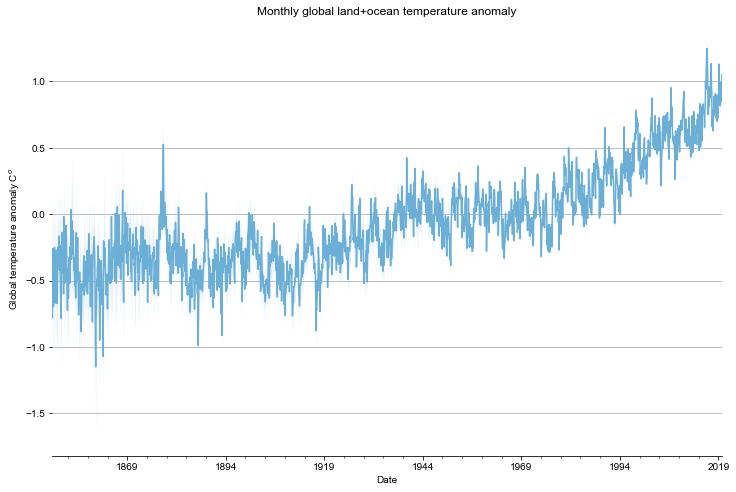

In [26]:
# Set dimensions
fig, ax = plt.subplots(figsize=(12, 8))

# Configure style
sns.set(style="whitegrid")
sns.despine(left=True,top=True,bottom=False)

# Plot Confidence bands
tempdata.MonthlyUp.plot(kind='line',alpha=0)
tempdata.MonthlyLo.plot(kind='line',alpha=0)

# Plot lines
tempdata.MonthlyAnomaly.plot(kind='line',color='#6baed6')

# Fill confidence band
d = tempdata.index.values
plt.fill_between(d, tempdata.MonthlyUp, 
                 tempdata.MonthlyLo, 
                 where = tempdata.MonthlyUp>=tempdata.MonthlyLo,
                 facecolor = '#6baed6', 
                 alpha=0.2)

# Tweak appearance
ax.set_title('Monthly global land+ocean temperature anomaly')
ax.set_ylabel('Global temperature anomaly C$^{o}$')
ax.grid(axis='x')

plt.show()

There is a significant month to month variance in the monthly global mean temperature anomalies,so the underlying trend is likely obscured by the random noise in monthly averages. Below we show the data that is smoothed with an annual moving average. The light blue area represents a 95% confidence interval to include statistical and spatial sampling errors. 

The pattern in this analysis is consistent with a long-term trend towards global warming. 2016 is the warmest year on record, and 2019 the second warmest year on record. We can see that the average annual global temperature has increased at least 1.5 degrees celcius in the last 150 years.

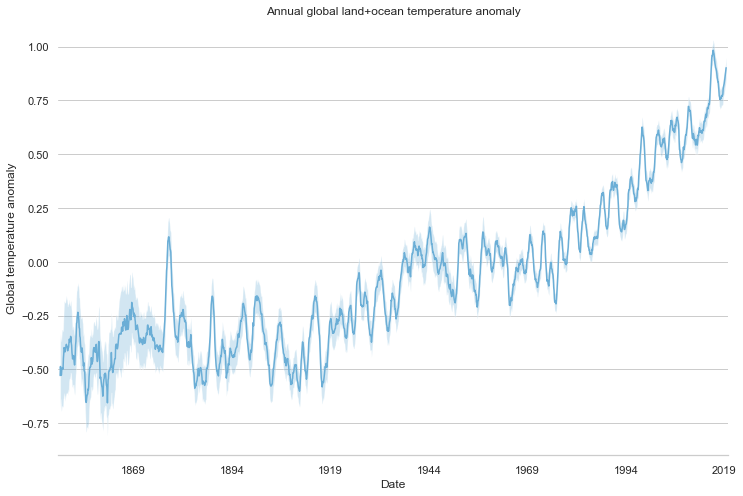

In [27]:
# Set dimensions
fig, ax = plt.subplots(figsize=(12, 8))

# Configure style
sns.set(style="whitegrid")
sns.despine(left=True,top=True,bottom=False)

# Plot confidence bands
tempdata.AnnualUp.plot(kind='line',alpha=0)
tempdata.AnnualLo.plot(kind='line',alpha=0)

# Plot lines
tempdata.AnnualAnomaly.plot(kind='line',color='#6baed6')

# Fill confidence bands
d = tempdata.index.values
plt.fill_between(d, tempdata.AnnualUp, 
                 tempdata.AnnualLo, 
                 where = tempdata.AnnualUp>=tempdata.AnnualLo,
                 facecolor = '#6baed6', 
                 alpha=0.3)

# Tweak appearance
ax.set_title('Annual global land+ocean temperature anomaly')
ax.set_ylabel('Global temperature anomaly')
ax.grid(axis='x')

plt.show()

From one year to the next, the annual average temperatures still reflects short-term natural variability. The chart below overlays the annual temperature with the ten year smooth average temperature anomaly. It makes much clearer the long-term trends towards global warming.

The blue line shows the same annual smoothed average global temperature, and the red line represents the ten year smoothed average temperature anomaly.

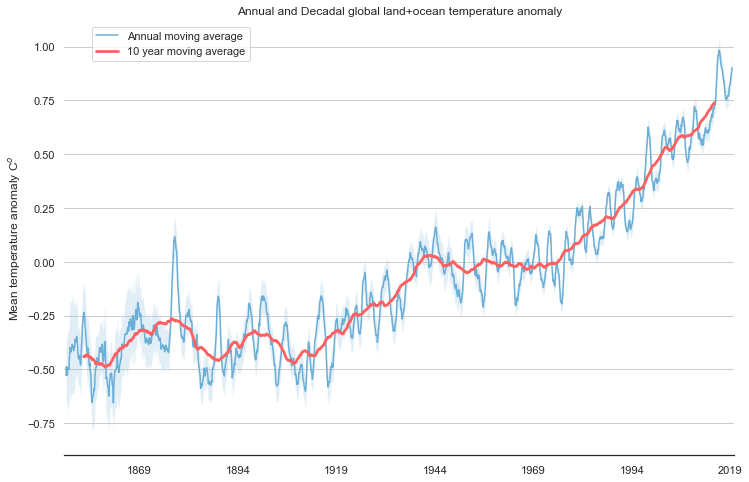

In [29]:
# Set dimensions
fig, ax = plt.subplots(figsize=(12, 8))

# Configure style
sns.set(style="white")
sns.despine(left=True,top=True,bottom=False)

# Plot Confidence bands
tempdata.AnnualUp.plot(kind='line',alpha=0,label='')
tempdata.AnnualLo.plot(kind='line',alpha=0,label='')

# Plot lines
tempdata.AnnualAnomaly.plot(kind='line',color='#6baed6',
                            label='Annual moving average')
tempdata.TenYearAnomaly.plot(kind='line',color='#FF6061',linewidth=2.75,
                             label='10 year moving average')

# Fill confidence band
d = tempdata.index.values
plt.fill_between(d, tempdata.AnnualUp, 
                 tempdata.AnnualLo, 
                 where = tempdata.AnnualUp>=tempdata.AnnualLo,
                 facecolor = '#6baed6', 
                 alpha=0.2)

# Tweak appearance
ax.set_title('Annual and Decadal global land+ocean temperature anomaly')
ax.set_ylabel('Mean temperature anomaly C$^{o}$')
ax.set_xlabel('')
ax.grid(axis='y')
ax.figure.legend(loc='upper left' , bbox_to_anchor=(0.1, 0.80))

# Display figure and save
plt.show()
output = Wr.makeOutFile('GlobalAnnualTenAnomaly.png')
fig.savefig(output,transparent=True)

### Heatmapping the global temperature anomaly since 1850

For an interesting visualisation exercise, below we are some heatmaps of the global average temperature anomaly. In each heat map, the x-axis are the years, with each y-axis being the month.  We show the data with the monthly average, an annual moving average, five year moving average, and ten year moving average.

Note that the monthly resolution heatmap does now show a strong seasonality, since the northern and southern hemispheres follow opposite seasons. There is a very mild seasonality, biased towards northern hemisphere seasonal patterns due to an asymmetric distrubution of land about the equater. This however, is hidden by the larger movements in temperature anomaly over many years.

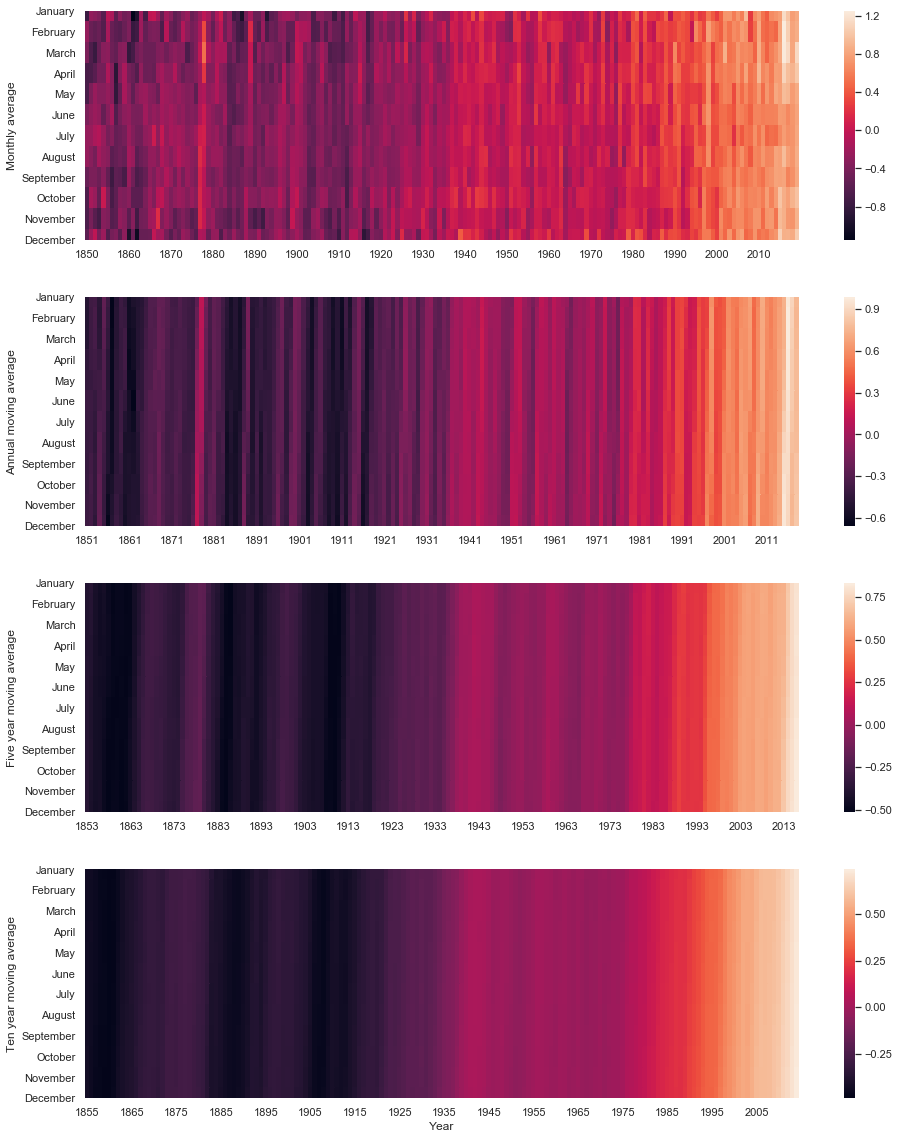

In [33]:
f, axes = plt.subplots(4, 1, figsize=(16, 20))

heat1 = sns.heatmap(monthData, xticklabels=10, ax=axes[0])
heat1.set_ylabel('Monthly average')
heat1.set_xlabel('')

heat2 = sns.heatmap(annualData, xticklabels=10, ax=axes[1])
heat2.set_ylabel('Annual moving average')
heat2.set_xlabel('')

heat3 = sns.heatmap(fiveYearData, xticklabels=10, ax=axes[2])
heat3.set_ylabel('Five year moving average')
heat3.set_xlabel('')

heat4 = sns.heatmap(tenYearData, xticklabels=10, ax=axes[3])
heat4.set_ylabel('Ten year moving average')


plt.subplots_adjust(hspace = 0.25)


The heat map using the five year moving average smoothing feels like the most aesthetically pleasing presentation, like a smooth oil painting. This of course, is personal preference.

We will export the charts at the monthly and 5 year moving average

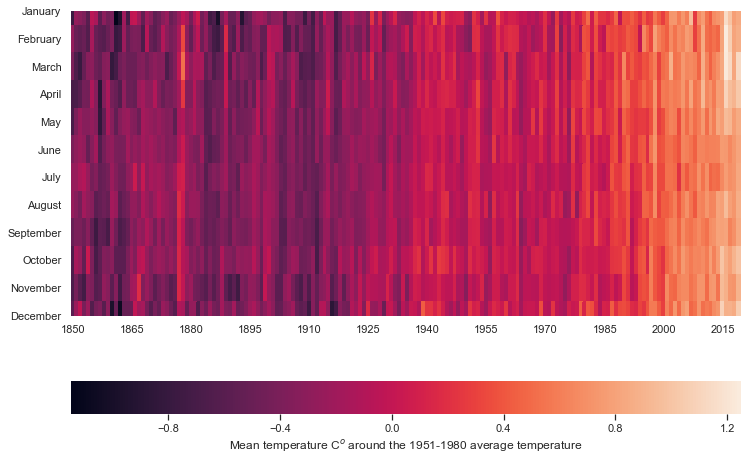

In [35]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12, 8))
heatmap = sns.heatmap(monthData, xticklabels=15,
                      cbar_kws={'label': 'Mean temperature C$^{o}$ around the 1951-1980 average temperature', 
                                'orientation': 'horizontal'})
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()
output = Wr.makeOutFile('monthlyheatmap.png')
figure = heatmap.get_figure()    
figure.savefig(output,transparent=True)

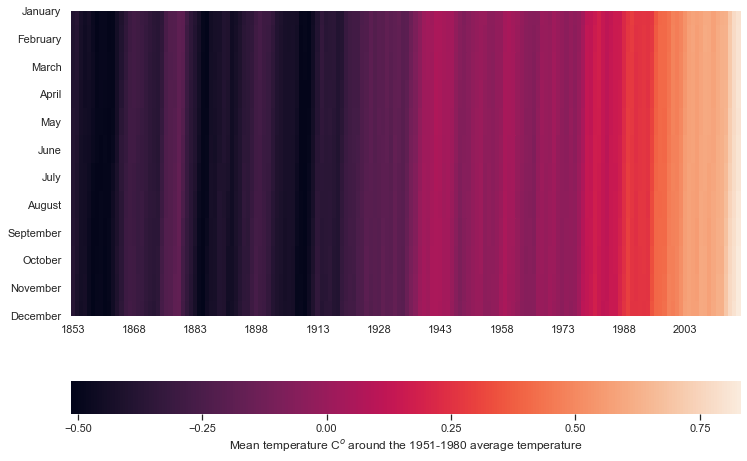

In [36]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12, 8))
heatmap = sns.heatmap(fiveYearData, xticklabels=15,
                      cbar_kws={'label': 'Mean temperature C$^{o}$ around the 1951-1980 average temperature',
                                'orientation': 'horizontal'})
ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_title('Heatmap of 5-year global moving avg temperatures',fontsize=30,fontfamily='helvetica')
plt.show()
output = Wr.makeOutFile('fiveyearheatmap.png')
figure = heatmap.get_figure()    
figure.savefig(output,transparent=True)

I took some inspiration from Ed Hawkins' climate stripes visualisation, which was shown in the economist's article linked below.
https://www.economist.com/leaders/2019/09/19/the-climate-issue

Here we show the annualised average 'heat map' with each stripe representing the average global temperature anomaly for the year. Darker blues represent cooler temperatures, and darker reds represent warmer temperatures. The less saturated lighter colours represent temperatures close to the average 1951-1980 global temperature

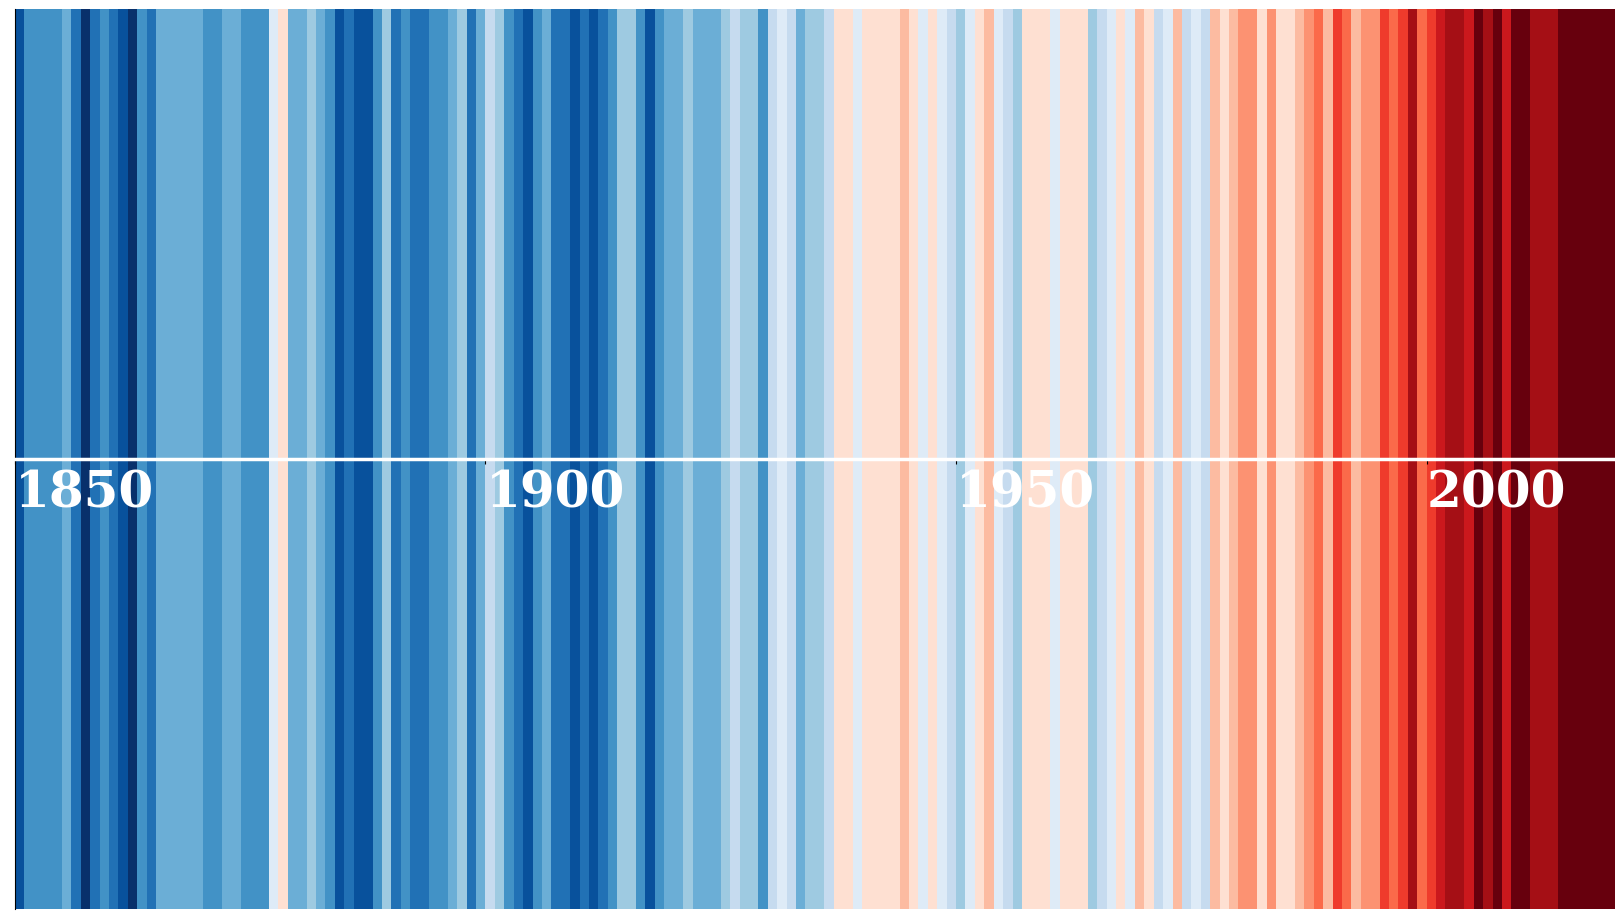

In [37]:
sns.reset_defaults()
Hs.makestripes(tempdata,'Global',xtrigger=True,save = True)

## Global atmospheric CO2 levels

In [38]:
# Create a combined temperature and CO2 dataset
co2Tempdata = tempdata.dropna(subset=['co2Trend'])

The analysis below shows the atmospheric CO$_{2}$ readings at the Mauna Loa observatory since 1958. The actual monthly levels are shown with the blue line, and displays a clear seasonality. The red line represents the smoothed average, and is consistent with a clear upward trend in atmospheric CO$_{2}$.

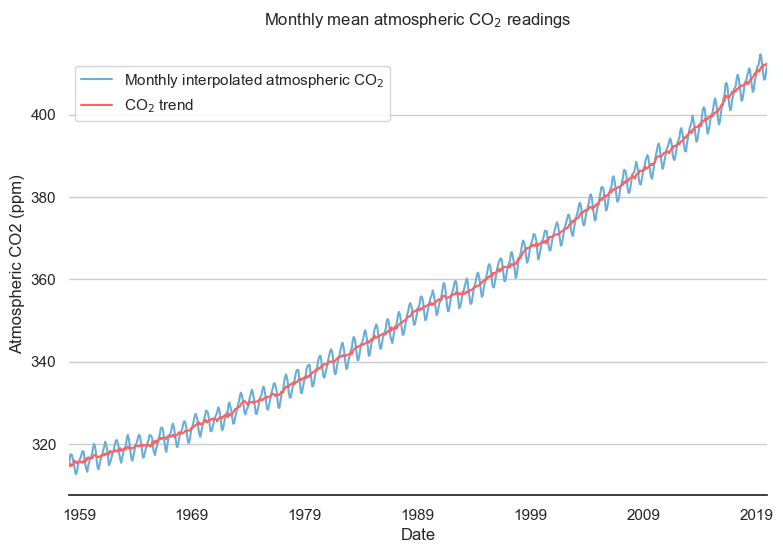

In [47]:
# Set dimensions
fig, ax = plt.subplots(figsize=(9, 6))

# Configure style
sns.set(style="white")
sns.despine(left=True,top=True,bottom=False)

# Plot the interpolated CO2 and CO2 trend data
co2Tempdata.co2Interpolated.plot(kind='line',color='#6baed6',label='Monthly interpolated atmospheric CO$_{2}$')
co2Tempdata.co2Trend.plot(kind='line',color='#FF6061',label='CO$_{2}$ trend')

# Tweak appearance
ax.set_title('Monthly mean atmospheric CO$_{2}$ readings')
ax.set_ylabel('Atmospheric CO2 (ppm)')
ax.grid(axis='y')
ax.figure.legend(loc='upper left' , bbox_to_anchor=(0.075, 0.825))

plt.show()

Combining the global average temperature anomaly (ten year average smoothed), with the atmospheric CO2 levels, we can see a very close linear correlation between CO2 levels and global temperature anomalies.

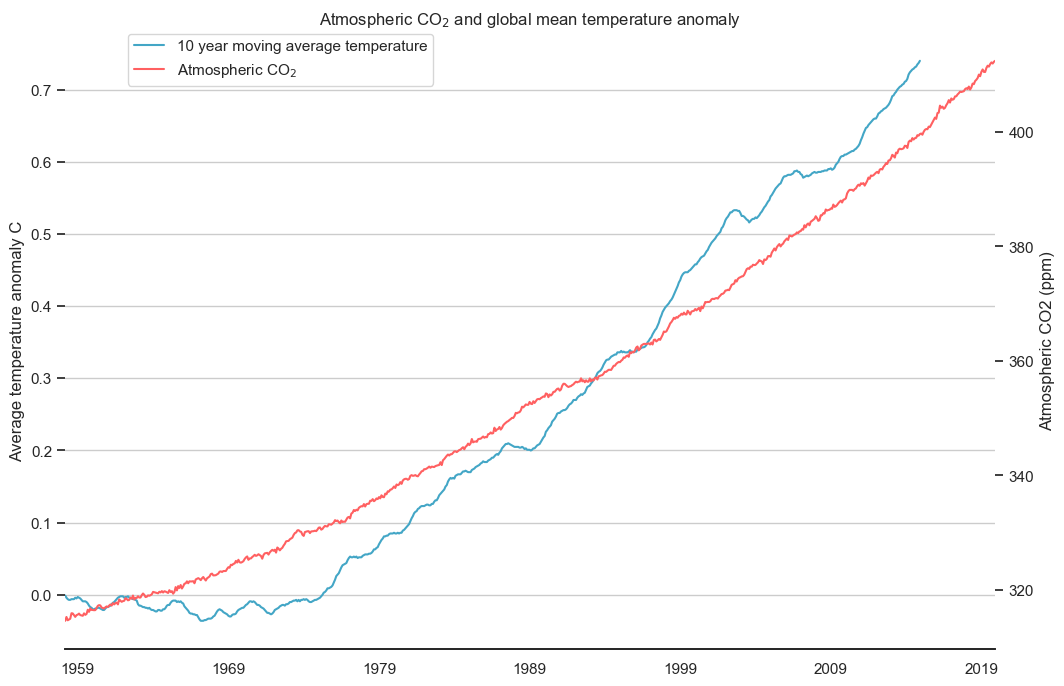

In [48]:
# Set dimensions
fig, ax = plt.subplots(figsize=(12, 8))

# Configure style
sns.set(style="white")

# Plot primary axis as decadal temperature anomaly
ax1 = co2Tempdata.TenYearAnomaly.plot(kind='line',color='#43A6C6',label='10 year moving average temperature')
ax1.set_ylabel('Average temperature anomaly C')

# Plot secondary axis as CO2 trend
ax2 = ax.twinx()
co2Tempdata.co2Trend.plot(kind='line',color='#FF6061',ax=ax2, label = 'Atmospheric CO$_{2}$')
ax2.set_ylabel('Atmospheric CO2 (ppm)')

# Tweak appearance
ax.set_title('Atmospheric CO$_{2}$ and global mean temperature anomaly')
ax.grid(axis='y')
ax.set_xlabel('')
ax.figure.legend(loc='upper left' , bbox_to_anchor=(0.1, 0.825))
sns.despine(left=True,top=True,bottom=False)

plt.show()
output = Wr.makeOutFile('TempCO2correlation.png')
fig.savefig(output,transparent=True)

# Ice age historical climate records

Svante Arrhenius, was the first chemist to propose that increases in atmospheric carbon dioxide will lead to increases in temperature via the greenhouse effect. This led to the hypothesis that a large part of the difference intemperature between the ice ages and the warm "interglacials" that separated them was down to carbon dioxide. 

We start below with evidence from Antarctic ice-cores showing the atmospheric carbon dioxide levels up to four hundred thousand years ago. Each of the coloured blue bars show an interglacial period, which is a period in history with warmer than average global temperatures. In each of the interglacials, the interglacials is about 1.45 times higher than it is during an ice age.

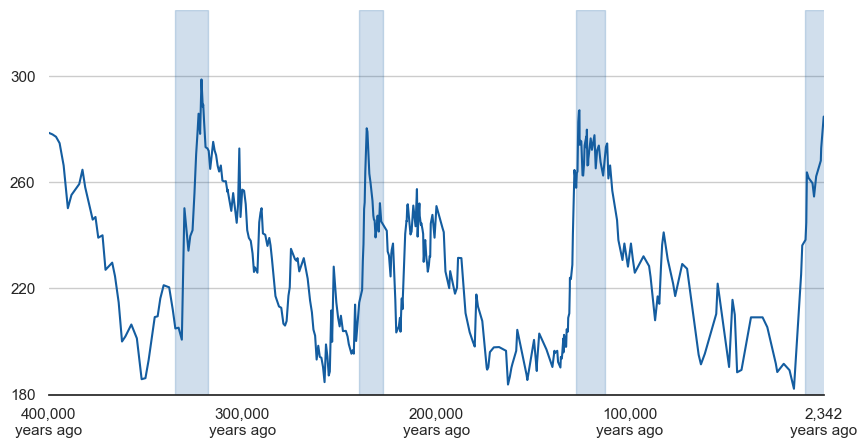

In [167]:
# Set dimensions
fig, ax = plt.subplots(figsize=(10, 5))

# Configure style
sns.set(style="white")
sns.despine(left=True,top=True,bottom=False)

# Plot CO2 level data
plt.plot(vosCO2Data.Mean_age_of_air_yrBP,vosCO2Data.CO2_conc_ppmv,color='#145DA0')

# Set Interglacial period bars
ax.axvspan(320000, 337000, alpha=0.2, color='#145DA0')
ax.axvspan(242000, 230000, alpha=0.2, color='#145DA0')
ax.axvspan(130000, 115000, alpha=0.2, color='#145DA0')
ax.axvspan(12000, 0, alpha=0.2, color='#145DA0')

# Set x and y axis boundary limits
ax.set_xlim(400000,2342)
ax.set_ylim(180,325)

# Configure x axis labels
plt.xticks(np.arange(2342,500000,step=100000),('2,342\nyears ago','100,000\nyears ago','200,000\nyears ago',
                                            '300,000\nyears ago','400,000\nyears ago'))

# Configure yticks
plt.yticks(np.arange(180,340,step=40))

# Tweak appearance
ax.grid(axis='y')

plt.show()
output = Wr.makeOutFile('CO2Past.png')
fig.savefig(output,transparent=True)

The Antarctic Vostok ice-core also contains evidence of global average temperature variance around the mean for four hundred thousand years. This shows a very clear pattern of both the carbon dioxide levels and temperature variances moving in synchrony. This data provides a very strong confidence that global average temperatures usually coincides with the rise and fall of atompsheric carbon dioxide.

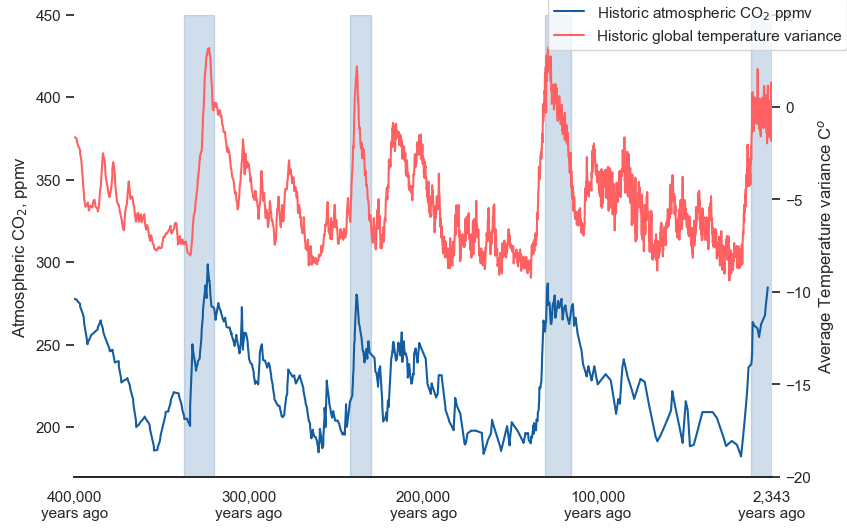

In [157]:
# Set dimensions
fig, ax = plt.subplots(figsize=(9, 6))

# Configure style
sns.set(style="white")

# Plot the historical CO2 records
ax1 = joinedVos.CO2Inter.plot(kind='line',color='#145DA0',label='Historic atmospheric CO$_{2}$ ppmv')
plt.xlabel('')

# Plot historical temperature variance
ax2 = ax.twinx()
ax2 = joinedVos.TempInter.plot(kind='line',color='#FF6061',ax=ax2,label='Historic global temperature variance')

# Set x and y axis boundaries
ax1.set_ylim(170,450)
ax2.set_ylim(-20,5)
ax.set_xlim(400000,0)

# Set interglacial period bands
ax.axvspan(320000, 337000, alpha=0.2, color='#145DA0')
ax.axvspan(242000, 230000, alpha=0.2, color='#145DA0')
ax.axvspan(130000, 115000, alpha=0.2, color='#145DA0')
ax.axvspan(12000, 0, alpha=0.2, color='#145DA0')

# Configure x axis labels
plt.xticks(np.arange(0,500000,step=100000),('2,343\nyears ago','100,000\nyears ago','200,000\nyears ago',
                                            '300,000\nyears ago','400,000\nyears ago'))

# Tweak appearance
# ax.set_title('Historic atmospheric CO$_{2}$ and global temperature variance',fontsize=30,fontfamily='helvetica')
sns.despine(left=True,top=True,bottom=False)
ax.figure.legend(loc='upper left', bbox_to_anchor=(0.6, 0.90))
ax.set_ylabel('Atmospheric CO$_{2}$, ppmv')
ax2.set_ylabel('Average Temperature variance C$^{o}$')

plt.show()
output = Wr.makeOutFile('HistoricCO2andTemp.png')
fig.savefig(output,transparent=True)

The ancient historical records places the current anthropogenic industrial impact on climate change into a very unnerving context. 

We have seen evidence that historical temperatures increase linearly with atmopsheric carbon dioxide. An important factor contributing to the difference in temperatures between the ice ages and warmer 'interglacials' was down to carbon dioxide. It is worth mentioning however, that carbon dioxide itself is not likely to have caused the interglacials. It is understood that fluctuations in the amount of solar radiation is largely responsible for the regular interglacial periods. The release of carbon dioxide gases as a result of the warming however, amplifies the warming effect. This leads to a spiralling effect where carbon dioxide is both the cause and effect of the warming.

The analysis below shows why the current increase in carbon dioxide levels is unlikely to be caused by solar activity. We see below that the current levels are even higher than the carbon dioxide levels typical of an interglacial. Today's warming is a particular anomaly in the history of hundreds of thousands of years. There are higher levels of carbon dioxide, and warmer temperatures today than in the last four hundred thousand years. The world is at the cusp of a new climate age.

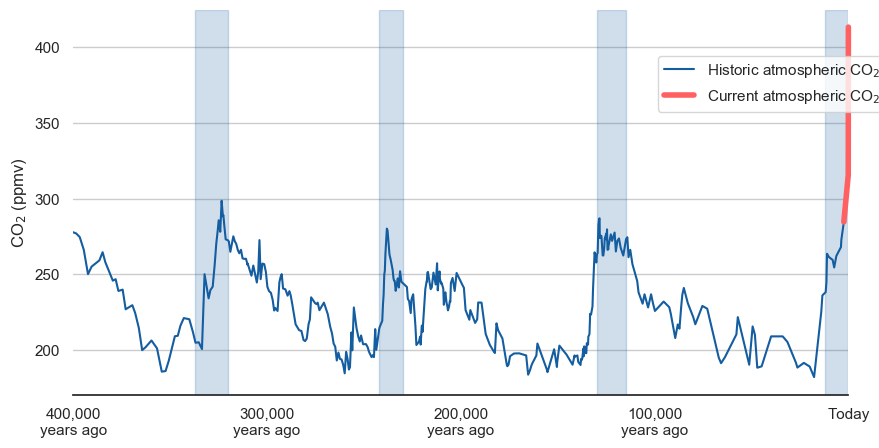

In [173]:
# Set dimensions
fig, ax = plt.subplots(figsize=(10, 5))

# Configure style
sns.set(style="white")
sns.despine(left=True,top=True,bottom=False)

# Plot historical and current CO2 levels
fullCO2Data.CO2_conc_ppmv.plot(kind='line',color='#145DA0',label='Historic atmospheric CO$_{2}$')
fullCO2Data.CO2Presentppm.plot(kind='line',linewidth=4,clip_on=False,color='#FF6061',
                              label='Current atmospheric CO$_{2}$')

# Set interglacial period bands
ax.axvspan(320000, 337000, alpha=0.2, color='#145DA0')
ax.axvspan(242000, 230000, alpha=0.2, color='#145DA0')
ax.axvspan(130000, 115000, alpha=0.2, color='#145DA0')
ax.axvspan(12000, 0, alpha=0.2, color='#145DA0')

# Set x axis limit
ax.set_xlim(400000,0)

# Configure x and labels
plt.xticks(np.arange(0,500000,step=100000),('Today','100,000\nyears ago','200,000\nyears ago',
                                            '300,000\nyears ago','400,000\nyears ago'))

# Tweak appearance
# ax.set_title('Historic atmospheric CO$_{2}$ and the present',fontsize=30,fontfamily='helvetica')
ax.grid(axis='y')
plt.ylabel('CO$_{2}$ (ppmv)')
plt.xlabel('')
ax.figure.legend(loc='upper left' , bbox_to_anchor=(0.65, 0.8))

plt.show()
output = Wr.makeOutFile('CO2PastandPresent.png')
fig.savefig(output,transparent=True)